Mounted at /content/gdrive
Found 2505 images belonging to 10 classes.
Found 621 images belonging to 10 classes.
58889256/58889256 [==============================] - 3s 0us/step


Epoch 1/30
78/78 [==============================] - 1755s 22s/step - loss: 6.0071 - accuracy: 0.3118 - val_loss: 2.7864 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 2/30
78/78 [==============================] - 132s 2s/step - loss: 2.6065 - accuracy: 0.4400 - val_loss: 1.9051 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 3/30
78/78 [==============================] - 132s 2s/step - loss: 2.1677 - accuracy: 0.4739 - val_loss: 1.6913 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 4/30
78/78 [==============================] - 132s 2s/step - loss: 2.0083 - accuracy: 0.4577 - val_loss: 1.5171 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 5/30
78/78 [==============================] - 132s 2s/step - loss: 1.8450 - accuracy: 0.5135 - val_loss: 1.4662 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 6/30
78/78 [==============================] - 132s 2s/step - loss: 1.8894 - accuracy: 0.4743 - val_loss: 1.5659 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 7/30
78/78 [==============================] - 131s 2s/step - loss: 1

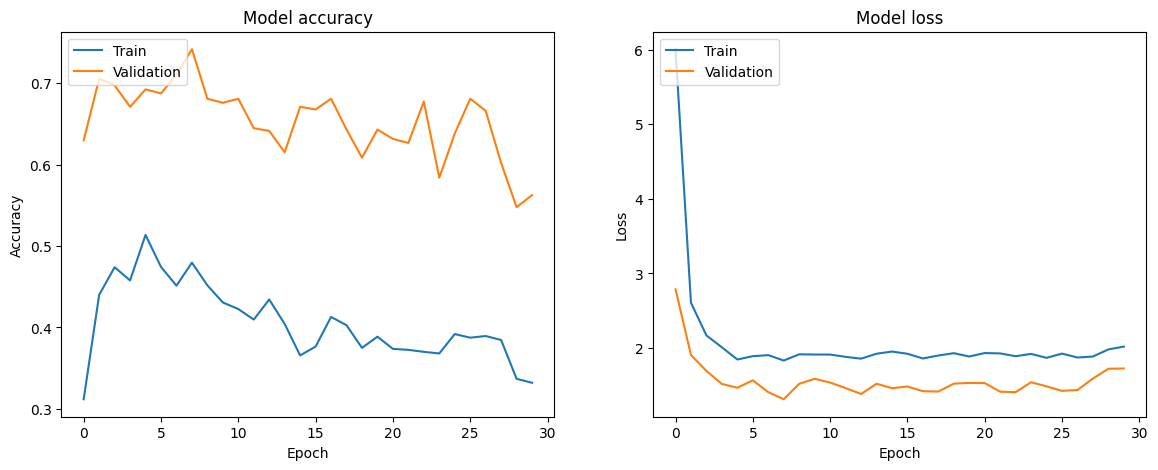

1/1 [==============================] - 1s 797ms/step


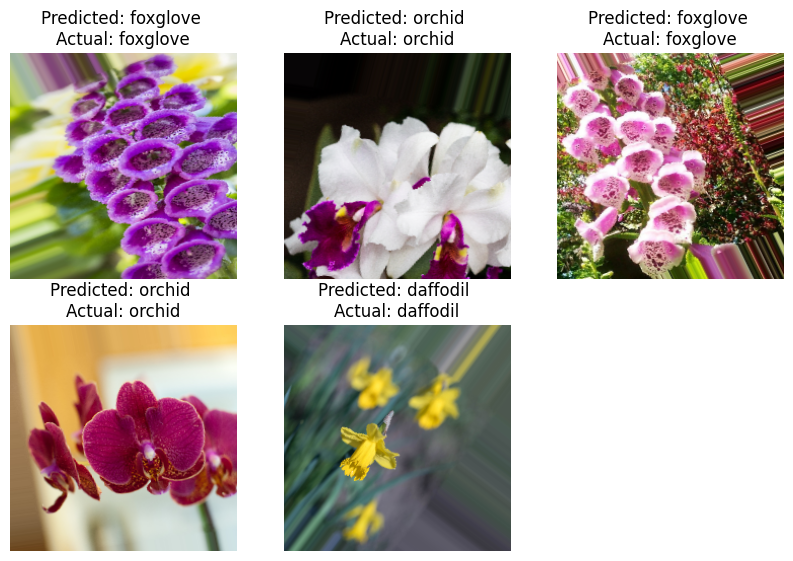

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Your dataset directory
data_dir = '/content/gdrive/My Drive/Combined flowers'

# Initialize ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,    # increased rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Prepare the training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Define the model
model = Sequential()
model.add(baseModel)

# Block 1
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Freeze the baseModel layers to not be trainable
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the reduce learning rate callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model for more epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    callbacks=[reduce_lr])

# Make sure y_true corresponds to actual labels in validation set
y_true = []
y_pred = []
for i in range(validation_generator.samples // validation_generator.batch_size):
    x, y = next(validation_generator)
    y_true.extend(np.argmax(y, axis=1))
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))

# Print classification report and confusion matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

# Save the model and the label to index mapping
model_path = '/content/gdrive/My Drive/simple_cnn_flower_classification_model.h5'
model.save(model_path)

label2index = train_generator.class_indices
label2index_path = '/content/gdrive/My Drive/label2index.json'

with open(label2index_path, 'w') as f:
    json.dump(label2index, f)

# Plot training & validation accuracy values
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Displaying actual and predicted correct/incorrect flowers
x, y_true = next(validation_generator)
y_true = np.argmax(y_true, axis=1)

# Predict on the batch of data
y_pred = model.predict(x)
y_pred = np.argmax(y_pred, axis=1)

# Get the 'true' label names
label_map = validation_generator.class_indices
label_map = {v:k for k, v in label_map.items()}  # flip k,v to v,k

# Display a few correctly classified images
correct_indices = np.where(y_pred == y_true)[0]
if len(correct_indices) > 0:
    plt.figure(figsize=(10, 10))
    for i, correct_index in enumerate(correct_indices[:9]):
        plt.subplot(3, 3, i + 1)
        image = x[correct_index]
        plt.imshow(image)
        plt.title(f"Predicted: {label_map[y_pred[correct_index]]} \nActual: {label_map[y_true[correct_index]]}")
        plt.axis('off')
plt.show()

# New Section